# Week 5 - Feature Engineering: Traversals Part 2
### March 24, 2017

#### Objectives
Continue previous feature engineering efforts by exploring the following:
    1. New Regression Models: k-Nearest Neighbors, Random Forest
    2. Box Cox Transformations
    3. Addition of histograms of models' results
    
#### Note
This notebook works with data involving *all* ICU readmission stays. It was decided that the interval approach, which filtered for stays with readmissions within a specific time window, was not appropriate.

In [1]:
import psycopg2
from psycopg2 import extras
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
import sys, os

%matplotlib inline

In [2]:
def cursor_connect(cursor_factory=None):
    """
    Connects to the DB and returns the connection and cursor, ready to use.
    
    Parameters
    ----------
    cursor_factory : psycopg2.extras
    
    Returns
    -------
    (psycopg2.extensions.connection, psycopg2.extensions.cursor)
        A tuple of (psycopg2 connection, psycopg2 cursor).
    """
    #DB connection
    conn = psycopg2.connect(dbname="mimic", user="mimic", host="localhost", port="2345",
                            password="oNuemmLeix9Yex7W")
    if not cursor_factory:
        cur = conn.cursor()
    else:
        cur = conn.cursor(cursor_factory=cursor_factory)
    return conn, cur

def exec_query(query, curs_dict=False):
    """
    Execute query and returns the SQL output.
    
    Parameters
    ----------
    query: string containing SQL SELECT command
    curs_dict: dict cursor factory (output is dict)
    
    Returns
    -------
    rows: list of rows/records (SQL output)
    """
    if curs_dict == True: 
        conn, cur = cursor_connect(psycopg2.extras.DictCursor)
    else:
        conn, cur = cursor_connect()
    cur.execute(query)
    rows = cur.fetchall()
    return rows

# Dataset

## Exclusion Criteria
1. Minors

## Features (`X`)

* **`subjectid`**: subject ID of patients
* **`icustayid`**: ID of a unique ICU stay
* **`readm_days`**: number of days since discharge of previous ICU stay
* **`prev_iculos`**: total length of stay (LOS) of the previous unique ICU stay
* **`N`<sub>icutrav</sub>**: the number of total intra-ICU ward transfers (non-unique ICU stays)
* **`prev_cu`**: categorical feature indicating previous care unit
* **`curr_cu`**: categorical feature indicating current care unit
* **`prev_ICU`**: binary feature indicating if previous care unit was an ICU type
* **`disch_cu`**: categorical feature indicating discharge care unit from ICU stay
* **`disch_ICU`**: binary feature indicating if discharge care unit was an ICU type
* **`icu_in_day`**: time of ICU admission (day/night)
* **`icu_out_day`**: time of ICU discharge (day/night)
* **`readm_risk`**: risk score of intra-patient unique ICU readmissions
* Transfer Pairs
    * **`nonicu-MICU`**	
    * **`nonicu-SICU`**	
    * **`nonicu-TSICU`**	
    * **`nonicu-CSRU`**	
    * **`MICU-MICU`**	
    * **`TSICU-TSICU`**	
    * **`nonicu-CCU`**	
    * **`CCU-CCU`**
    * **`CSRU-CSRU`**	
    * **`SICU-SICU`**	
 
## Dependent Variables/Response (`Y`) 
  * **`icu_los`**: ICU length of stay

### Unique ICU stays

Features:
  * **`subjectid`**: subject ID of patients
  * **`icustaysid`**: ID of a unique ICU stay
  * **`readm_days`**: number of days since discharge of previous ICU stay to admission of current ICU stay (ICU readmission)

In [3]:
def prev_icutime(data):
    if data['readm_days'] == np.nan:
        pass
    else:
        prev_icutime = data['icu_intime'] - data['readm_days'] # time of previous ICU discharge/transfer
        return prev_icutime

In [5]:
# query
q_icustay="""SELECT subject_id, icustay_id, min_in, max_out,
min_in - lag(max_out)
OVER (PARTITION BY subject_id ORDER BY min_in) AS diff
FROM
(SELECT subject_id, icustay_id, 
MIN(intime) as min_in, MAX(outtime) AS max_out
FROM transfers
WHERE icustay_id IS NOT NULL
GROUP BY subject_id, icustay_id) as sub_q
ORDER BY subject_id
"""

# Query output
icustay = exec_query(q_icustay)
df_icustay = pd.DataFrame(icustay, columns=['subjectid',
                                            'icustayid', 
                                            'icu_intime', # first unique ICU admission time 
                                            'icu_outtime', #  unique ICU discharge time
                                            'readm_days']) # number of days since last ICU discharge/transfer

df_icustay['icu_prev_outtime'] = df_icustay.apply(prev_icutime, axis=1)
# df_icustay.readm_days.fillna(0, inplace=True)
df_icustay.readm_days.dropna(inplace=True)
df_icustay['readm_days'] = np.round(df_icustay['readm_days'].astype(int) * (1/8.64e13), 3)
print df_icustay.shape
df_icustay.head()

(61532, 6)


,subjectid,icustayid,icu_intime,icu_outtime,readm_days,icu_prev_outtime
0,2,243653,2138-07-17 21:20:07,2138-07-17 23:32:21,NaN,NaT
1,3,211552,2101-10-20 19:10:11,2101-10-26 20:43:09,NaN,NaT
2,4,294638,2191-03-16 00:29:31,2191-03-17 16:46:31,NaN,NaT
3,5,214757,2103-02-02 06:04:24,2103-02-02 08:06:00,NaN,NaT
4,6,228232,2175-05-30 21:30:54,2175-06-03 13:39:54,NaN,NaT


Filter for patients with ICU readmissions.

In [6]:
# query
q_readm_pat ="""SELECT * FROM
    (SELECT subject_id, COUNT(icustay_id) AS n_icustays
    FROM icustays
    GROUP BY subject_id) AS sub_q
WHERE n_icustays > 1;"""

# Query output
readm_pat = exec_query(q_readm_pat, False)
df_readm_pat = pd.DataFrame(readm_pat, columns=['subjectid', 'n_icustays'])

df_readm = df_icustay[df_icustay['subjectid'].isin(df_readm_pat.subjectid)]
print df_readm.shape
df_readm.head()

(23811, 6)


,subjectid,icustayid,icu_intime,icu_outtime,readm_days,icu_prev_outtime
5,7,278444,2121-05-23 15:35:29,2121-05-23 22:01:00,NaN,NaT
6,7,236754,2121-05-25 03:26:01,2121-05-25 21:10:19,1.226,2121-05-23 22:01:00
14,17,277042,2134-12-27 16:21:48,2134-12-29 18:04:03,NaN,NaT
15,17,257980,2135-05-09 14:12:06,2135-05-10 11:18:34,130.839,2134-12-29 18:04:03
19,21,217847,2134-09-11 20:50:04,2134-09-17 18:28:32,NaN,NaT


Extract prior ICUstay ID through `icu_prior_outtime`.

**Note**: Some ICUstays have duplicate entries (use of `DISTINCT ON` prevents duplicates)

In [7]:
q_previcu = """SELECT DISTINCT ON (subject_id, icustay_id, outtime) subject_id, icustay_id, outtime 
FROM transfers 
WHERE icustay_id IS NOT NULL;
"""
# Query output
prev_icustay = exec_query(q_previcu)
df_previcu = pd.DataFrame(prev_icustay, columns=['subjectid', 'prev_icustayid', 'icu_prev_outtime'])

df_readm = pd.merge(df_readm, df_previcu, on=['subjectid', 'icu_prev_outtime'], how='left')
df_readm.drop(labels='icu_prev_outtime', axis=1, inplace=True)
df_readm.head()

,subjectid,icustayid,icu_intime,icu_outtime,readm_days,prev_icustayid
0,7,278444,2121-05-23 15:35:29,2121-05-23 22:01:00,NaN,NaN
1,7,236754,2121-05-25 03:26:01,2121-05-25 21:10:19,1.226,278444.0
2,17,277042,2134-12-27 16:21:48,2134-12-29 18:04:03,NaN,NaN
3,17,257980,2135-05-09 14:12:06,2135-05-10 11:18:34,130.839,277042.0
4,21,217847,2134-09-11 20:50:04,2134-09-17 18:28:32,NaN,NaN


## Exclusion

#### Neonate Patients

In [8]:
q_nicu = """SELECT DISTINCT icustay_id FROM transfers              
WHERE curr_careunit = 'NICU' AND icustay_id IS NOT NULL;
"""
nicu_stays = exec_query(q_nicu)
df_nicu_stays = pd.DataFrame(nicu_stays, columns=['icustayid'])

df_readm = df_readm[df_readm['icustayid'].isin(df_nicu_stays.icustayid)==False]
df_readm.shape

(23357, 6)

#### Minors

In [9]:
# age of patients < 90
q_age_hadm1 = """SELECT a.subject_id,
    FLOOR((a.admittime::date - p.dob::date)/365.0) AS age
    FROM admissions as a
    INNER JOIN patients as p
    ON a.subject_id = p.subject_id
    WHERE FLOOR((a.admittime::date - p.dob::date)/365.0) < 90;"""

# adjusted age of patients > 89
q_age_hadm2 = """SELECT a.subject_id,
    FLOOR((a.admittime::date - p.dob::date)/365.0) -210 AS age
    FROM admissions as a
    INNER JOIN patients as p
    ON a.subject_id = p.subject_id
    WHERE FLOOR((a.admittime::date - p.dob::date)/365.0) > 89;"""

age_hadm1 = exec_query(q_age_hadm1, False)
age_hadm2 = exec_query(q_age_hadm2, False)
df_age_hadm1 = pd.DataFrame(age_hadm1, columns=['subjectid', 'age'])
df_age_hadm2 = pd.DataFrame(age_hadm2, columns=['subjectid', 'age'])

df_age_hadm = pd.concat([df_age_hadm1, df_age_hadm2])
df_adults = df_age_hadm[df_age_hadm.age > 17]
df_adults_sid = list(df_adults.subjectid.value_counts().index.sort_values())

df_readm = df_readm[df_readm.subjectid.isin(df_adults_sid)]
df_readm.shape

(23353, 6)

### Previous ICU LOS
The total LOS of the previous unique ICU stay, *includes the duration of all intra-ICU stays*.

In [10]:
q_prevlos = """SELECT icustay_id, los 
FROM icustays;"""

prevlos = exec_query(q_prevlos)
df_prevlos = pd.DataFrame(prevlos, columns=['prev_icustayid', 'prev_iculos'])

df_readm1 = pd.merge(df_readm, df_prevlos, on='prev_icustayid', how='left')

print df_readm1.shape
df_readm1.head()

(23353, 7)


,subjectid,icustayid,icu_intime,icu_outtime,readm_days,prev_icustayid,prev_iculos
0,17,277042,2134-12-27 16:21:48,2134-12-29 18:04:03,NaN,NaN,NaN
1,17,257980,2135-05-09 14:12:06,2135-05-10 11:18:34,130.839,277042.0,2.0710
2,21,217847,2134-09-11 20:50:04,2134-09-17 18:28:32,NaN,NaN,NaN
3,21,216859,2135-01-30 20:53:34,2135-02-08 05:38:46,135.101,217847.0,5.9017
4,23,227807,2153-09-03 09:38:55,2153-09-04 15:59:11,NaN,NaN,NaN


### N<sub>icutrav</sub>
The number of total *ICU* ward transfers for each patient's unique ICU stay. The value indicates the number of (non-unique) intra-ICU ward transfers.

In [11]:
q_multtrav = """SELECT icustay_id, COUNT(*)
FROM transfers
WHERE icustay_id IS NOT NULL
GROUP BY icustay_id"""

mult_trav = exec_query(q_multtrav)
df_multtrav = pd.DataFrame(mult_trav, columns=['icustayid', 'n_icutrav'])
df_readm2 = pd.merge(df_readm1, df_multtrav, on='icustayid', how='left')

print df_readm2.shape
df_readm2.head()

(23353, 8)


,subjectid,icustayid,icu_intime,icu_outtime,readm_days,prev_icustayid,prev_iculos,n_icutrav
0,17,277042,2134-12-27 16:21:48,2134-12-29 18:04:03,NaN,NaN,NaN,1
1,17,257980,2135-05-09 14:12:06,2135-05-10 11:18:34,130.839,277042.0,2.0710,1
2,21,217847,2134-09-11 20:50:04,2134-09-17 18:28:32,NaN,NaN,NaN,2
3,21,216859,2135-01-30 20:53:34,2135-02-08 05:38:46,135.101,217847.0,5.9017,1
4,23,227807,2153-09-03 09:38:55,2153-09-04 15:59:11,NaN,NaN,NaN,1


### Current Care Unit
Type of ICU admitted/transferred into.

**`prev_cu`**: categorical feature indicating previous care unit  
**`curr_cu`**: categorical feature indicating current care unit  
**`prev_ICU`**: binary feature indicating previous ICU  

Legend:
  * nonICU : 0
  * MICU : 1
  * CSRU : 2
  * SICU : 3
  * CCU : 4 
  * TSICU : 5
  * NICU :6 
  * NWARD :7

In [12]:
def binary_cu(careunit):
    if careunit > 0 and careunit < 7:
        x = 1
    else:
        x = 0
    return x

In [13]:
q_careunit = """SELECT DISTINCT ON (icustay_id, intime) icustay_id, 
intime, curr_careunit, prev_careunit
FROM transfers WHERE icustay_id IS NOT NULL;"""

careunit = exec_query(q_careunit)
df_careunit = pd.DataFrame(careunit, 
                           columns = ['icustayid', 'icu_intime', 
                                      'curr_cu', 'prev_cu'])

df_careunit.prev_cu.replace(to_replace = 
                            {'':0, 'MICU':1, 'CSRU': 2, 'SICU': 3, 'CCU': 4, 
                             'TSICU': 5,  'NICU':6, 'NWARD':7}, inplace=True)
df_careunit.curr_cu.replace(to_replace = 
                            {'':0, 'MICU':1, 'CSRU': 2, 'SICU': 3, 'CCU': 4, 
                             'TSICU': 5,  'NICU':6, 'NWARD':7}, inplace=True)

df_careunit['prev_ICU'] = df_careunit.prev_cu.apply(binary_cu)
# df_careunit['curr_ICU'] = df_careunit.curr_cu.apply(binary_cu)

df_readm3 = pd.merge(df_readm2, df_careunit, on=['icustayid', 'icu_intime'], how='left')

print df_readm3.shape
df_readm3.head()

(23353, 11)


,subjectid,icustayid,icu_intime,icu_outtime,readm_days,prev_icustayid,prev_iculos,n_icutrav,curr_cu,prev_cu,prev_ICU
0,17,277042,2134-12-27 16:21:48,2134-12-29 18:04:03,NaN,NaN,NaN,1,2,0,0
1,17,257980,2135-05-09 14:12:06,2135-05-10 11:18:34,130.839,277042.0,2.0710,1,2,0,0
2,21,217847,2134-09-11 20:50:04,2134-09-17 18:28:32,NaN,NaN,NaN,2,4,0,0
3,21,216859,2135-01-30 20:53:34,2135-02-08 05:38:46,135.101,217847.0,5.9017,1,1,0,0
4,23,227807,2153-09-03 09:38:55,2153-09-04 15:59:11,NaN,NaN,NaN,1,2,0,0


### ICU Discharge Care Unit
Ward patient was transferred to after ICU stay.

  * **`disch_cu`**: categorical feature indicating discharge unit from ICU
  * **`disch_ICU`**: binary feature indicating ICU discharge

Legend:
  * nonICU : 0
  * MICU : 1
  * CSRU : 2
  * SICU : 3
  * CCU : 4 
  * TSICU : 5
  * NICU :6 
  * NWARD :7
  
**Note**: Some records are missing information such as transfer from an ICU, indicating the end of the ICU stay. These `NULL` rows have been omitted.

In [14]:
q_disch = """SELECT DISTINCT ON (t1.outtime) t1.subject_id, t1.icustay_id, t2.curr_careunit, t1.outtime 
FROM
  (SELECT * FROM transfers WHERE curr_careunit LIKE '%U') as t1
INNER JOIN
  (SELECT * FROM transfers WHERE prev_careunit != '') as t2
ON t1.outtime = t2.intime"""

disch_unit = exec_query(q_disch)
df_disch = pd.DataFrame(disch_unit, 
                        columns=['subjectid', 'icustayid', 'disch_cu', 'icu_outtime'])
df_disch['disch_cu'].replace(to_replace = 
                            {'':0, 'MICU':1, 'CSRU': 2, 'SICU': 3, 'CCU': 4, 
                             'TSICU': 5,  'NICU':6, 'NWARD':7}, inplace=True)

df_disch['disch_ICU'] = df_disch.disch_cu.apply(binary_cu)

df_readm4 = pd.merge(df_readm3, df_disch[['icustayid', 'disch_cu', 'icu_outtime', 'disch_ICU']], 
                       on=['icustayid', 'icu_outtime'], how='inner')
print df_readm4.shape
df_readm4.head()

(23345, 13)


,subjectid,icustayid,icu_intime,icu_outtime,readm_days,prev_icustayid,prev_iculos,n_icutrav,curr_cu,prev_cu,prev_ICU,disch_cu,disch_ICU
0,17,277042,2134-12-27 16:21:48,2134-12-29 18:04:03,NaN,NaN,NaN,1,2,0,0,0,0
1,17,257980,2135-05-09 14:12:06,2135-05-10 11:18:34,130.839,277042.0,2.0710,1,2,0,0,0,0
2,21,217847,2134-09-11 20:50:04,2134-09-17 18:28:32,NaN,NaN,NaN,2,4,0,0,0,0
3,21,216859,2135-01-30 20:53:34,2135-02-08 05:38:46,135.101,217847.0,5.9017,1,1,0,0,0,0
4,23,227807,2153-09-03 09:38:55,2153-09-04 15:59:11,NaN,NaN,NaN,1,2,0,0,0,0


### ICU Time (Day/Night)
Time of ICU "admission" and "discharge" (day or night)

Features
  * **`icu_in_day`**: Time of ICU admission
  * **`icu_out_day`**: Time of ICU discharge

Legend:
  * **`0`**: night
  * **`1`**: day

In [15]:
def day_night(datetime):
    hour = np.timedelta64(np.datetime64(datetime, 'h') - (np.datetime64(datetime, 'D')), 'h')
    if hour.astype(np.int64) >=6 and hour.astype(np.int64) <=18:
        time = 1 # day
    else:
        time = 0 # night
    return time

In [16]:
df_readm4['icu_in_day'] = df_readm4['icu_intime'].apply(day_night)
df_readm4['icu_out_day'] = df_readm4['icu_outtime'].apply(day_night)
print df_readm4.shape
df_readm4.head()

(23345, 15)


,subjectid,icustayid,icu_intime,icu_outtime,readm_days,prev_icustayid,prev_iculos,n_icutrav,curr_cu,prev_cu,prev_ICU,disch_cu,disch_ICU,icu_in_day,icu_out_day
0,17,277042,2134-12-27 16:21:48,2134-12-29 18:04:03,NaN,NaN,NaN,1,2,0,0,0,0,1,1
1,17,257980,2135-05-09 14:12:06,2135-05-10 11:18:34,130.839,277042.0,2.0710,1,2,0,0,0,0,1,1
2,21,217847,2134-09-11 20:50:04,2134-09-17 18:28:32,NaN,NaN,NaN,2,4,0,0,0,0,0,1
3,21,216859,2135-01-30 20:53:34,2135-02-08 05:38:46,135.101,217847.0,5.9017,1,1,0,0,0,0,0,0
4,23,227807,2153-09-03 09:38:55,2153-09-04 15:59:11,NaN,NaN,NaN,1,2,0,0,0,0,1,1


### ICU Readmission
Risk Scores based on ICU readmissions (*multiple unique ICU admissions within the specified interval*).

**`Risk Score = N`<sub>ICU readmission</sub> ` = N`<sub>Total ICU admissions</sub>` - 1`**  
The value of the risk score indicates the count/frequency of readmission for the given ICU stay.
 * `0`: indicates first ICU stay during the interval
 * `2`: indicates 3 total ICU stays and 2 ICU readmissions during the interval 

In [17]:
# df_icustay4['icustayid'].groupby(df_icustay4['subjectid']).agg('count'-9'')
d_risk = dict()
for i, row in df_readm4.iterrows():
    if d_risk.has_key(row.subjectid):
        d_risk[row.subjectid]['count'] += 1
        d_risk[row.subjectid][row.icustayid] = d_risk[row.subjectid]['count'] 

    else:
        d_icu = {'count': 0}
        d_icu[row.icustayid] = d_icu['count']
        d_risk[row.subjectid] = d_icu
        
        
df_readm4['readm_risk'] = df_readm4.subjectid.astype(str)+'-'+df_readm4.astype(str).icustayid

In [18]:
def intra_interval(stay):
    risk_score = str.split(stay, '-')
    sid = int(risk_score[0])
    stayid = int(risk_score[1])
    
    return d_risk[sid][stayid]    

In [19]:
df_readm4['readm_risk'] = df_readm4['readm_risk'].apply(intra_interval)
print df_readm4.shape
df_readm4.head()

(23345, 16)


,subjectid,icustayid,icu_intime,icu_outtime,readm_days,prev_icustayid,prev_iculos,n_icutrav,curr_cu,prev_cu,prev_ICU,disch_cu,disch_ICU,icu_in_day,icu_out_day,readm_risk
0,17,277042,2134-12-27 16:21:48,2134-12-29 18:04:03,NaN,NaN,NaN,1,2,0,0,0,0,1,1,0
1,17,257980,2135-05-09 14:12:06,2135-05-10 11:18:34,130.839,277042.0,2.0710,1,2,0,0,0,0,1,1,1
2,21,217847,2134-09-11 20:50:04,2134-09-17 18:28:32,NaN,NaN,NaN,2,4,0,0,0,0,0,1,0
3,21,216859,2135-01-30 20:53:34,2135-02-08 05:38:46,135.101,217847.0,5.9017,1,1,0,0,0,0,0,0,1
4,23,227807,2153-09-03 09:38:55,2153-09-04 15:59:11,NaN,NaN,NaN,1,2,0,0,0,0,1,1,0


### Traversal Pairs
**Feature transformation** The probability of the feature combination pair is used as weight and applied onto the count for each row.

**Note**: The overall hospital admission LOS may be extracted by taking the aggregate mean of the DataFrame, after it has been grouped by `subject_id`.

In [20]:
q_trav = """SELECT subject_id, icustay_id, eventtype,
prev_careunit, curr_careunit
FROM transfers
WHERE icustay_id IS NOT NULL;"""
mult_trav = exec_query(q_trav, False)
mult_col = ['subjectid', 'icustayid', 'eventtype', 'prev_cu', 'curr_cu']
df_trav = pd.DataFrame(mult_trav, columns = mult_col)
df_trav.replace(to_replace='', value=np.nan, inplace=True, regex=True)

df_trav = df_trav[df_trav.prev_cu != 'NICU']
df_trav = df_trav[df_trav.prev_cu != 'NWARD']
df_trav = df_trav[df_trav.curr_cu != 'NICU']
df_trav = df_trav[df_trav.curr_cu != 'NWARD']
df_trav.prev_cu.fillna('nonicu', inplace=True)
df_trav.curr_cu.fillna('nonicu', inplace=True)

df_trav['trans'] = df_trav.prev_cu+'-'+df_trav.curr_cu

# Filter for Patients with ICU readmission
q_icupat="""SELECT * FROM
    (SELECT subject_id, COUNT(icustay_id) AS n_icustays
    FROM icustays
    GROUP BY subject_id) AS sub_q
WHERE n_icustays > 1;"""

icupat = exec_query(q_icupat)
df_icupat = pd.DataFrame(icupat, columns=['subjectid', 'n_icustays'])
df_icupat
# filter for ICU patients with readmissions
filter_preadm = list(df_icupat.subjectid)
df_trav = df_trav[df_trav.subjectid.isin(filter_preadm)]

In [21]:
from collections import Counter

icuid = list(df_trav.icustayid.value_counts().index) # unique subject_id

main_d = dict()
for stay in icuid:
    pair_d = dict(Counter(df_trav[df_trav.icustayid==stay].trans))
    pair_d['icustayid'] = stay # add subjectid key
    main_d[stay] = pair_d

#### Count of Traversal Pair

In [22]:
df_toppairs = df_trav.trans.value_counts(ascending=False).to_frame()
df_top = df_toppairs.transpose().iloc[:,0:11]

df_pairct = pd.DataFrame.from_dict(main_d, orient='index')

# drop non-top trans pair cols
pairs_drop = list(df_toppairs.iloc[10:].index)
df_pairct.drop(pairs_drop, axis=1, inplace=True) 

df_readm5 = pd.merge(df_readm4, df_pairct, on='icustayid', how='left')

#### Probability Transformation (Weight)

In [23]:
prev_cu = df_trav.prev_cu
curr_cu = df_trav.curr_cu
pair_prob = pd.crosstab(prev_cu, curr_cu) / pd.crosstab(prev_cu, curr_cu).sum()
pair_prob

curr_cu,CCU,CSRU,MICU,SICU,TSICU
prev_cu,,,,,
CCU,0.058462,0.029022,0.018337,0.009021,0.008323
CSRU,0.039126,0.230929,0.008767,0.011963,0.007491
MICU,0.039126,0.012852,0.100891,0.036478,0.032043
SICU,0.012056,0.006633,0.015488,0.083742,0.014149
TSICU,0.009099,0.003731,0.010520,0.018631,0.110695
nonicu,0.842129,0.716833,0.845996,0.840165,0.827299


In [24]:
df_pairprob = pair_prob.unstack().to_frame(name='prob').reset_index()
df_pairprob['trans'] = df_pairprob.prev_cu+'-'+df_pairprob.curr_cu
df_pairprob.drop(['curr_cu', 'prev_cu'], axis=1, inplace=True)
df_pairprob.set_index('trans', drop=True, inplace=True)
# df_pairprob.sort_values('prob', ascending=False).head()

In [25]:
pairs = ['nonicu-MICU', 'nonicu-SICU', 'nonicu-TSICU', 'nonicu-CSRU',
         'MICU-MICU', 'TSICU-TSICU', 'nonicu-CCU', 'CCU-CCU', 'CSRU-CSRU',
         'SICU-SICU']

for elem in pairs:
    df_readm5[elem].fillna(0, inplace=True)
    df_readm5[elem] = np.round(df_readm5[elem] * df_pairprob.loc[elem].values[0],3)
    
print df_readm5.shape
df_readm5.head()

(23345, 26)


,subjectid,icustayid,icu_intime,icu_outtime,readm_days,prev_icustayid,prev_iculos,n_icutrav,curr_cu,prev_cu,...,nonicu-SICU,nonicu-CSRU,nonicu-MICU,MICU-MICU,nonicu-TSICU,nonicu-CCU,TSICU-TSICU,SICU-SICU,CSRU-CSRU,CCU-CCU
0,17,277042,2134-12-27 16:21:48,2134-12-29 18:04:03,NaN,NaN,NaN,1,2,0,...,0.0,0.717,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.000
1,17,257980,2135-05-09 14:12:06,2135-05-10 11:18:34,130.839,277042.0,2.0710,1,2,0,...,0.0,0.717,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.000
2,21,217847,2134-09-11 20:50:04,2134-09-17 18:28:32,NaN,NaN,NaN,2,4,0,...,0.0,0.000,0.000,0.0,0.0,0.842,0.0,0.0,0.0,0.058
3,21,216859,2135-01-30 20:53:34,2135-02-08 05:38:46,135.101,217847.0,5.9017,1,1,0,...,0.0,0.000,0.846,0.0,0.0,0.000,0.0,0.0,0.0,0.000
4,23,227807,2153-09-03 09:38:55,2153-09-04 15:59:11,NaN,NaN,NaN,1,2,0,...,0.0,0.717,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.000


## Response Variable
### Average ICU LOS
Feature (Response): The average length of stay in the ICU (`icustay_id`) for each patient's hospital admission.
  * Feature is the response/dependent variable (`y`)

In [26]:
q_iculos = """SELECT icustay_id, los 
FROM icustays;"""

iculos = exec_query(q_iculos)
df_iculos = pd.DataFrame(iculos, columns=['icustayid', 'icu_los'])

df_icustay_f = pd.merge(df_readm5, df_iculos, on='icustayid', how='left')
df_icustay_f.fillna(0, inplace=True)
df_icustay_f['prev_icustayid'] = df_icustay_f['prev_icustayid'].astype(int)

print df_icustay_f.shape
df_icustay_f.head()

(23345, 27)


,subjectid,icustayid,icu_intime,icu_outtime,readm_days,prev_icustayid,prev_iculos,n_icutrav,curr_cu,prev_cu,...,nonicu-CSRU,nonicu-MICU,MICU-MICU,nonicu-TSICU,nonicu-CCU,TSICU-TSICU,SICU-SICU,CSRU-CSRU,CCU-CCU,icu_los
0,17,277042,2134-12-27 16:21:48,2134-12-29 18:04:03,0.000,0,0.0000,1,2,0,...,0.717,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.000,2.0710
1,17,257980,2135-05-09 14:12:06,2135-05-10 11:18:34,130.839,277042,2.0710,1,2,0,...,0.717,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.8795
2,21,217847,2134-09-11 20:50:04,2134-09-17 18:28:32,0.000,0,0.0000,2,4,0,...,0.000,0.000,0.0,0.0,0.842,0.0,0.0,0.0,0.058,5.9017
3,21,216859,2135-01-30 20:53:34,2135-02-08 05:38:46,135.101,217847,5.9017,1,1,0,...,0.000,0.846,0.0,0.0,0.000,0.0,0.0,0.0,0.000,8.3647
4,23,227807,2153-09-03 09:38:55,2153-09-04 15:59:11,0.000,0,0.0000,1,2,0,...,0.717,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.000,1.2641


## Composite Dataset
Drop unneeded features that were used for data engineering/feature extraction.
  * **`icu_intime`**
  * **`icu_outtime`**
  * **`prev_icustayid`**

In [27]:
df_icustay_f.drop(['icu_intime', 'icu_outtime', 'prev_icustayid'], axis=1, inplace=1)

print df_icustay_f.shape
df_icustay_f.head()

(23345, 24)


,subjectid,icustayid,readm_days,prev_iculos,n_icutrav,curr_cu,prev_cu,prev_ICU,disch_cu,disch_ICU,...,nonicu-CSRU,nonicu-MICU,MICU-MICU,nonicu-TSICU,nonicu-CCU,TSICU-TSICU,SICU-SICU,CSRU-CSRU,CCU-CCU,icu_los
0,17,277042,0.000,0.0000,1,2,0,0,0,0,...,0.717,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.000,2.0710
1,17,257980,130.839,2.0710,1,2,0,0,0,0,...,0.717,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.8795
2,21,217847,0.000,0.0000,2,4,0,0,0,0,...,0.000,0.000,0.0,0.0,0.842,0.0,0.0,0.0,0.058,5.9017
3,21,216859,135.101,5.9017,1,1,0,0,0,0,...,0.000,0.846,0.0,0.0,0.000,0.0,0.0,0.0,0.000,8.3647
4,23,227807,0.000,0.0000,1,2,0,0,0,0,...,0.717,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.000,1.2641


In [28]:
df_icustay_f.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23345 entries, 0 to 23344
Data columns (total 24 columns):
subjectid       23345 non-null int64
icustayid       23345 non-null int64
readm_days      23345 non-null float64
prev_iculos     23345 non-null float64
n_icutrav       23345 non-null int64
curr_cu         23345 non-null int64
prev_cu         23345 non-null int64
prev_ICU        23345 non-null int64
disch_cu        23345 non-null int64
disch_ICU       23345 non-null int64
icu_in_day      23345 non-null int64
icu_out_day     23345 non-null int64
readm_risk      23345 non-null int64
nonicu-SICU     23345 non-null float64
nonicu-CSRU     23345 non-null float64
nonicu-MICU     23345 non-null float64
MICU-MICU       23345 non-null float64
nonicu-TSICU    23345 non-null float64
nonicu-CCU      23345 non-null float64
TSICU-TSICU     23345 non-null float64
SICU-SICU       23345 non-null float64
CSRU-CSRU       23345 non-null float64
CCU-CCU         23345 non-null float64
icu_los         

In [29]:
df_icustay_f.describe()

,subjectid,icustayid,readm_days,prev_iculos,n_icutrav,curr_cu,prev_cu,prev_ICU,disch_cu,disch_ICU,...,nonicu-CSRU,nonicu-MICU,MICU-MICU,nonicu-TSICU,nonicu-CCU,TSICU-TSICU,SICU-SICU,CSRU-CSRU,CCU-CCU,icu_los
count,23345.000000,23345.000000,23345.000000,23345.000000,23345.000000,23345.000000,23345.000000,23345.000000,23345.0,23345.0,...,23345.000000,23345.00000,23345.000000,23345.000000,23345.000000,23345.000000,23345.000000,23345.000000,23345.000000,23345.000000
mean,33408.819747,249870.079075,196.154137,2.912094,1.302035,2.235639,0.000386,0.000171,0.0,0.0,...,0.106144,0.41943,0.005970,0.070287,0.133523,0.001264,0.001535,0.011013,0.000639,4.523062
std,27905.141177,28932.901004,477.668102,6.025804,0.652648,1.373317,0.029991,0.013089,0.0,0.0,...,0.270652,0.46432,0.027734,0.242899,0.325049,0.012998,0.012786,0.062373,0.006502,6.816350
min,17.000000,200001.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000100
25%,11825.000000,224749.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.293500
50%,24111.000000,250001.000000,6.487000,1.179200,1.000000,2.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.332800
75%,52952.000000,274975.000000,114.921000,3.064200,1.000000,3.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.84600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.713700
max,99982.000000,299998.000000,4116.430000,173.072500,9.000000,5.000000,3.000000,1.000000,0.0,0.0,...,2.867000,3.38400,0.504000,2.482000,2.526000,0.443000,0.335000,1.617000,0.175000,173.072500


### Correlation Heatmap
Pearson Correlation (linear relationship) between the target (`icu_los`) and explanatory variables. Those with a correlation coefficient of `NaN` indiciate that there is not much variation.

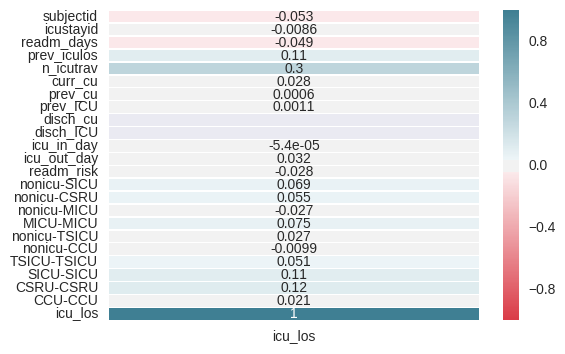

In [69]:
data_pcorr = df_icustay_f.corr()
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.heatmap(data_pcorr[['icu_los']], annot=True, cmap = cmap, 
            linewidths=0.3)

# Predictive Modeling

In [39]:
import sys, os
src_abspath = os.path.abspath(os.path.join(os.path.split(os.getcwd())[0], 'src'))
sys.path.append(src_abspath)
from db import *
from clf import *

In [32]:
am_debugging = True
if am_debugging:
    np.random.seed(2)
else:
    np.random.seed()

#### Partition: Training & Testing Sets

In [33]:
def data_partition(data, train_thres=0.75):
    """
    Helper function identifying indices for each record to be a part of the
    training set. The quantity of a given subject's set of records is determined
    by the training threshold.
    
    :param data: pandas DataFrame
    :param train_thres: float indicating threshold
    :return: list of training indices
    """
    if train_thres > 0.83:
        return "This helper function is not appropriate for training threshold > 83%."
    
    idx_lst = []
    subj_count = dict(Counter(data.subjectid))
    sid_lst = list(data.subjectid.value_counts().index.sort_values(ascending=True))
    for sid in sid_lst:
        idx_min = data['subjectid'][data.subjectid == sid].idxmin()
        if subj_count[sid] > 2:
            end_idx = idx_min + int(np.round(subj_count[sid] * train_thres))
            idx_lst += range(idx_min, end_idx)
        else:
            idx_lst += [idx_min]
    return idx_lst

In [34]:
data = df_icustay_f.copy().iloc[:1000, :]

train_idx = data_partition(data, 0.75)
train_data = data.ix[train_idx]
test_idx = data.index[data.index.isin(train_idx)==False]
test_data = data.ix[test_idx]

train_data.shape, test_data.shape

((613, 24), (387, 24))

In [35]:
X_train = train_data.iloc[:, :-1]
X_test = test_data.iloc[:, :-1]
y_train = np.array(train_data.iloc[:, -1])
y_test = np.array(test_data.iloc[:, -1])
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((613, 23), (387, 23), (613,), (387,))

#### Normalization

In [36]:
scaler = StandardScaler().fit(X_train) # scaler object fitted to training set

# Transform
scaled_X_train = scaler.transform(X_train)
scaled_X_test = scaler.transform(X_test)

scaled_X_train.shape, scaled_X_test.shape, y_train.shape, y_test.shape

((613, 23), (387, 23), (613,), (387,))

#### Feature Selection

In [37]:
# scaled_X_train, scaled_X_test = scale(X_train, X_test)
scaled_X_train.shape, scaled_X_test.shape, y_train.shape, y_test.shape

((613, 23), (387, 23), (613,), (387,))

In [38]:
pass

## Model: Linear Regression

In [97]:
lr_model, lr_pred, lr_p, lr_score = gridsearch(scaled_X_train, scaled_X_test, y_train)
print "Best Parameters: ", lr_p
print "Best Grid Search Score: ", lr_score
print "Best Estimator: ", lr_model, "\n"

Best Parameters:  {'normalize': True, 'fit_intercept': True}
Best Grid Search Score:  -0.00526567128334
Best Estimator:  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True) 



#### Compare Predictions

In [98]:
lr_pred[-10:]

array([ 8.70578441,  4.05202309,  7.17837721,  2.85373952,  6.98474154,
        2.98898567,  4.15137068,  4.33914333,  4.11737013,  4.79409011])

In [99]:
y_test[-10:]

array([ 11.6744,   9.2824,  21.8131,  11.6055,   4.5255,   4.0701,
         1.1331,   2.7381,   0.6534,   3.0686])

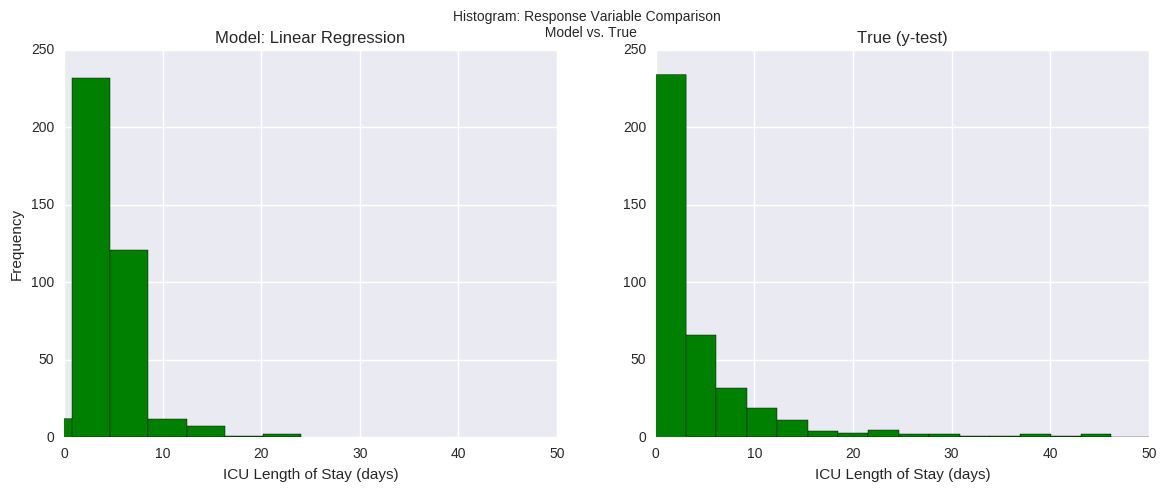

In [107]:
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
plt.hist(np.round(lr_pred), bins=7, color='g')
plt.title("Model: Linear Regression")
plt.xlabel('ICU Length of Stay (days)')
plt.ylabel('Frequency')
plt.xlim([0,50])
plt.ylim([0, 250])
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.hist(np.round(y_test), bins=25, color='g')
plt.title("True (y-test)")
plt.xlabel('ICU Length of Stay (days)')
plt.xlim([0,50])
plt.ylim([0, 250])
plt.legend(loc='upper right')
plt.suptitle('Histogram: Response Variable Comparison \n Model vs. True')

plt.show()

### Metrics

#### Root Mean Squared Error (RMSE)
Indicates the *absolute fit* of the model to the data. In other words, how close the observed data points are to the model's predicted values.

Also, it is the standard deviation of unexplained variance (residuals).

In [108]:
lr_rmse = RMSE(lr_pred, y_test)
print "RMSE = %.3f days" % lr_rmse

RMSE = 8.197 days


In [109]:
print "[%.2f,%.2f]" % (y_test.min(), y_test.max())

[0.21,76.92]


The linear regression model has an RMSE value of 8.2 days. The value is somewhat small relative to the range of the `dependent variable` (average ICU LOS). Thus, indicating that model has decent accuracy in predicting the response.

#### Mean Absolute Error
The Mean Absolute Error measures how close the model's predictions are to the observed values.

In [110]:
lr_mae = MAE(lr_pred, y_test)
print "MAE = %.3f days" % lr_mae

MAE = 2.589 days


The average difference between prediction and observation is 2.59 days, which is low.

#### R<sup>2</sup>: Coefficient of Determination
R<sup>2</sup> quantifies the goodness of fit of the linear model. More specifically, it depicts the predictive power of the model.

Range: [0, 1]

In [111]:
lr_r2 = r2(lr_pred, y_test)
print "r2 = %.3f" % lr_r2

r2 = 0.019


The R<sup>2</sup> value is approximately 0.02, which indicates that the model does not have strong predictive power.

## Model: Support Vector Regression

In [127]:
def svr_gridsearch(X_train, X_test, y_train):
    """
    Function determines the optimal parameters of the best classifier model/estimator by performing a grid search.
    The best model will be fitted with the Training set and subsequently used to predict the classification/labels
    of the Testing set. The function returns the "best" classifier instance, classifier predictions, best parameters,
    and grid score.

    :param X_train: Training set features
    :param X_test: Testing set features
    :param y_train: Training set labels
    :return: tuple of (best classifier instance, clf predictions, dict of best parameters, grid score)
    """
    # Parameter Grid - dictionary of parameters (map parameter names to values to be searched)
    param_grid = [
        {'C': [0.01, 0.1, 1, 10, 100, 1000], 'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10], 'kernel': ['linear']},
        {'C': [0.01, 0.1, 1, 10, 100, 1000], 'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10], 'kernel': ['rbf']}
#         {'C':[0.01, 0.1, 1, 10, 100, 1000], 'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10], 'degree': [2], 'kernel': ['poly']}
    ]

    
    # Blank clf instance
    blank_clf = SVR()

    # Grid Search - Hyperparameters Optimization
    clf = grid_search.GridSearchCV(blank_clf, param_grid, n_jobs=-1)  # classifier + optimal parameters
    clf = clf.fit(X_train, y_train)  # fitted classifier
    best_est = clf.best_estimator_
    clf_pred = best_est.predict(X_test)

    best_params = clf.best_params_  # best parameters identified by grid search
    score = clf.best_score_  # best grid score
    return (best_est, clf_pred, best_params, score)

In [128]:
svr_model, svr_pred, svr_p, svr_score = svr_gridsearch(scaled_X_train, scaled_X_test, y_train)
print "Best Parameters: ", svr_p
print "Best Grid Search Score: ", svr_score
print "Best Estimator: ", svr_model, "\n"

Best Parameters:  {'kernel': 'rbf', 'C': 10, 'gamma': 10}
Best Grid Search Score:  -0.0245207762812
Best Estimator:  SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=10,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False) 



#### Compare Predictions

In [129]:
svr_pred[-10:]

array([ 4.0417233 ,  4.0417233 ,  4.03671024,  4.0417233 ,  4.0417233 ,
        3.78649631,  4.04162042,  4.04371561,  4.04175748,  4.04155967])

In [130]:
y_test[-10:]

array([ 11.6744,   9.2824,  21.8131,  11.6055,   4.5255,   4.0701,
         1.1331,   2.7381,   0.6534,   3.0686])

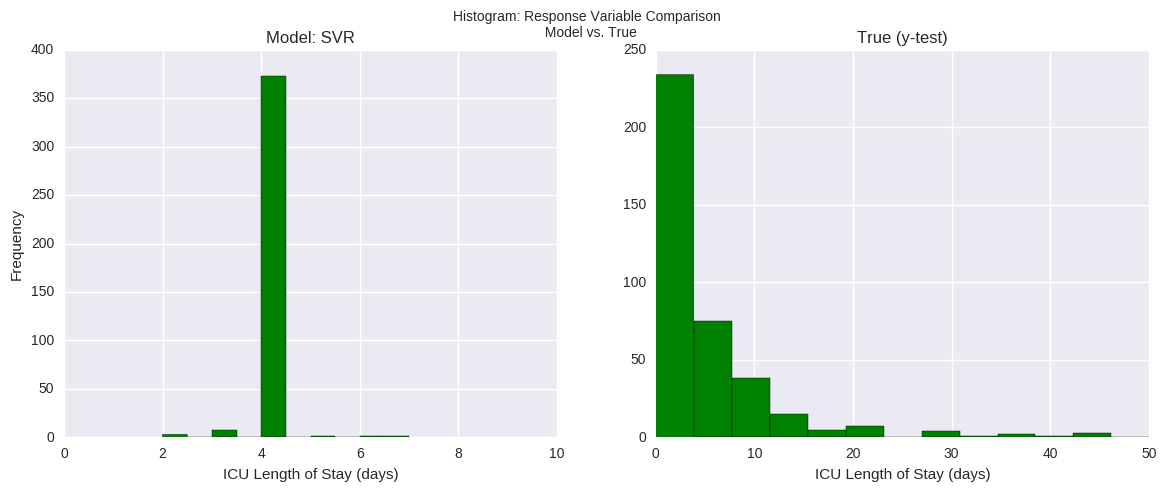

In [146]:
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
plt.hist(np.round(svr_pred), color='g')
plt.title("Model: SVR")
plt.xlabel('ICU Length of Stay (days)')
plt.ylabel('Frequency')
plt.xlim([0,10])
# plt.ylim([0, 250])
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.hist(np.round(y_test), bins=20, color='g')
plt.title("True (y-test)")
plt.xlabel('ICU Length of Stay (days)')
plt.xlim([0,50])
plt.ylim([0, 250])
plt.legend(loc='upper right')
plt.suptitle('Histogram: Response Variable Comparison \n Model vs. True')

plt.show()

### Metrics

#### Root Mean Squared Error (RMSE)
Indicates the *absolute fit* of the model to the data. In other words, how close the observed data points are to the model's predicted values.

Also, it is the standard deviation of unexplained variance (residuals).

In [142]:
svr_rmse = RMSE(svr_pred, y_test)
print "RMSE = %.3f days" % svr_rmse

RMSE = 8.392 days


In [143]:
print "[%.2f,%.2f]" % (y_test.min(), y_test.max())

[0.21,76.92]


The SVR model has an RMSE value of 8.4 days. The value is somewhat small relative to the range of the `dependent variable` (average ICU LOS). Thus, indicating that model has decent accuracy in predicting the response.

#### Mean Absolute Error
The Mean Absolute Error measures how close the model's predictions are to the observed values.

In [144]:
svr_mae = MAE(svr_pred, y_test)
print "MAE = %.3f days" % svr_mae

MAE = 2.407 days


The average difference between prediction and observation is 2.41 days, which is low.

#### R<sup>2</sup>: Coefficient of Determination
R<sup>2</sup> quantifies the goodness of fit of the linear model. More specifically, it depicts the predictive power of the model.

Range: [0, 1]

In [145]:
r2(svr_pred, y_test)

-0.027854378633343835

The R<sup>2</sup> value is approximately -0.03, which is low and indicates that the model does not have strong predictive power. The negative R<sup>2</sup> is out of range, indicating that the model can be arbitrarily worse. 

## Model: k-Nearest Neighbors

In [40]:
knn_model = KNeighborsRegressor(n_neighbors=5, weights='uniform') # look at 5 closest neighbors
knn_model.fit(scaled_X_train, y_train) # fit model on training data
knn_pred = knn_model.predict(scaled_X_test)

#### Compare Predictions

In [41]:
knn_pred[-10:]

array([ 6.52692,  3.5576 ,  7.01408,  3.60196,  6.88756,  2.22222,
        2.54172,  6.52692,  2.48348,  8.52266])

In [42]:
y_test[-10:]

array([ 11.6744,   9.2824,  21.8131,  11.6055,   4.5255,   4.0701,
         1.1331,   2.7381,   0.6534,   3.0686])

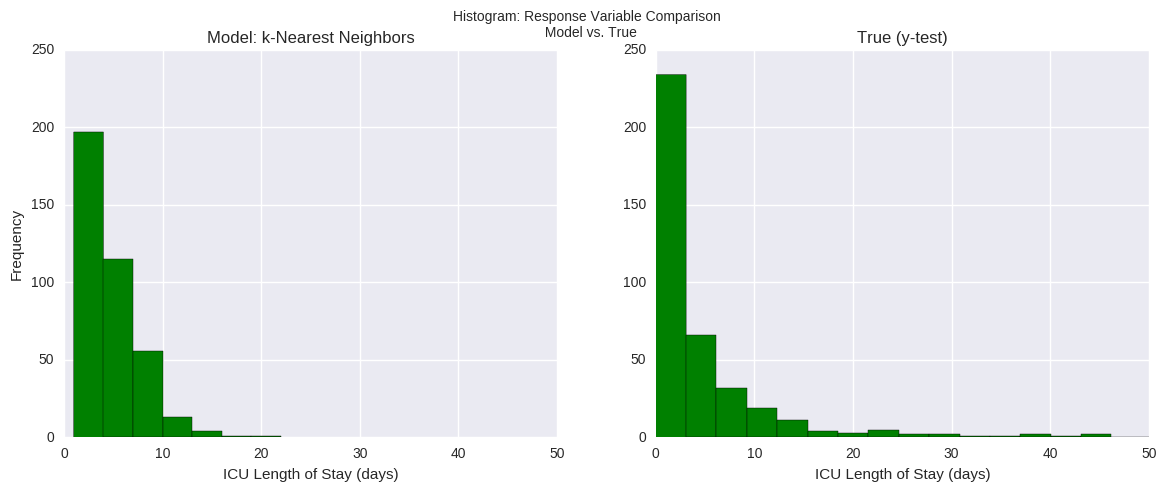

In [47]:
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
plt.hist(np.round(knn_pred), bins=7, color='g')
plt.title("Model: k-Nearest Neighbors")
plt.xlabel('ICU Length of Stay (days)')
plt.ylabel('Frequency')
plt.xlim([0,50])
plt.ylim([0, 250])
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.hist(np.round(y_test), bins=25, color='g')
plt.title("True (y-test)")
plt.xlabel('ICU Length of Stay (days)')
plt.xlim([0,50])
plt.ylim([0, 250])
plt.legend(loc='upper right')
plt.suptitle('Histogram: Response Variable Comparison \n Model vs. True')

plt.show()

### Metrics

#### Root Mean Squared Error (RMSE)
Indicates the *absolute fit* of the model to the data. In other words, how close the observed data points are to the model's predicted values.

Also, it is the standard deviation of unexplained variance (residuals).

In [52]:
knn_rmse = RMSE(knn_pred, y_test)
print "RMSE = %.3f days" % knn_rmse

RMSE = 8.485 days


In [53]:
print "[%.2f,%.2f]" % (y_test.min(), y_test.max())

[0.21,76.92]


The k-NN model has an RMSE value of 8.5 days. The value is somewhat small relative to the range of the `dependent variable` (average ICU LOS). Thus, indicating that model has decent accuracy in predicting the response.

#### Mean Absolute Error
The Mean Absolute Error measures how close the model's predictions are to the observed values.

In [54]:
knn_mae = MAE(knn_pred, y_test)
print "MAE = %.3f days" % knn_mae

MAE = 2.457 days


The average difference between prediction and observation is 2.46 days, which is relatively low.

#### R<sup>2</sup>: Coefficient of Determination
R<sup>2</sup> quantifies the goodness of fit of the linear model. More specifically, it depicts the predictive power of the model.

Range: [0, 1]

In [55]:
knn_r2 = r2(knn_pred, y_test)
print "r2 = %.2f" % knn_r2

r2 = -0.05


The k-NN model has poor predictive power. The negative R<sup>2</sup> is out of range, but possible as it indicates that the model can be arbitrarily worse. 

This may be attributed to the fact that it's a "lazy learning" algorithm, *lacking generalization*. The model only does work (build a model) at the time of prediction and uses minimal, if any Training data.

## Model: Random Forest

#### Criterion
  1. **mse**: mean squared error
  2. **mae**: mean absolute error

In [56]:
def rf_gridsearch(X_train, X_test, y_train):
    # Parameter Grid - dictionary of parameters (map parameter names to values to be searched)
    param_grid = [
        {'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 
         'criterion': ['mse', 'mae']}
    ]

    rfr = RandomForestRegressor(random_state=2, n_jobs=-1)

    # Grid search to find "best" random forest classifier -- Hyperparameters Optimization
    clf = grid_search.GridSearchCV(rfr, param_grid)  # classifier + optimal parameters
    clf = clf.fit(X_train, y_train)  # fitted classifier -- Training Set
    best_est = clf.best_estimator_
    clf_pred = best_est.predict(X_test)  # apply classifier on test set for label predictions
    params = clf.best_params_  # optimal parameters
    score = clf.best_score_  # best grid score
    imp = best_est.feature_importances_
    return (best_est, clf_pred, params, score, imp)

In [57]:
rf_model, rf_pred, rf_p, rf_score, rf_imp = rf_gridsearch(scaled_X_train, scaled_X_test, y_train)
print "Best Parameters: ", rf_p
print "Best Grid Search Score: ", rf_score
print "Best Estimator: ", rf_model

Best Parameters:  {'n_estimators': 10, 'criterion': 'mse'}
Best Grid Search Score:  -0.377553027826
Best Estimator:  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=-1, oob_score=False, random_state=2,
           verbose=0, warm_start=False) 



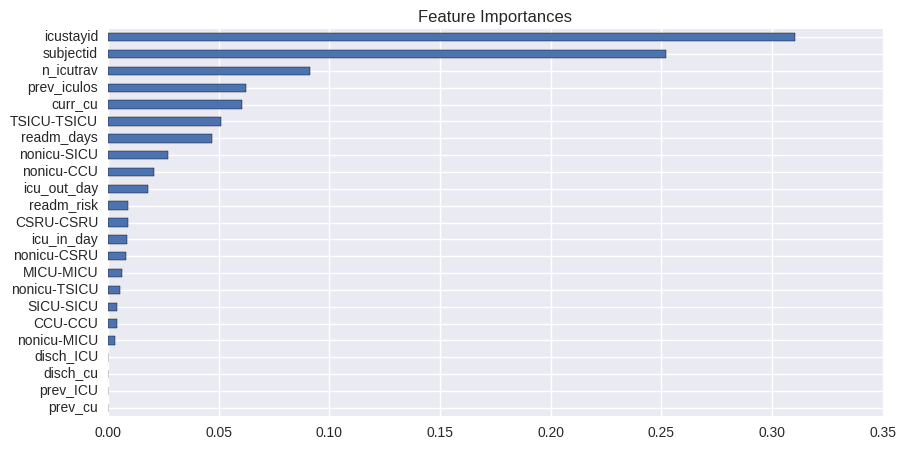

In [64]:
plt.figure(figsize=(10,5))
feats = data.drop('icu_los', axis=1)
feat_imp = pd.Series(rf_imp, 
                     index=feats.columns.values).sort_values(ascending=True)
feat_imp.plot(kind='barh')
plt.title('Feature Importances')

#### Compare Predictions

In [59]:
rf_pred[-10:]

array([ 13.9212 ,  10.25472,   9.79834,  16.17401,  13.26611,  11.52077,
        16.21562,  11.0287 ,   9.04833,   9.49219])

In [60]:
y_test[-10:]

array([ 11.6744,   9.2824,  21.8131,  11.6055,   4.5255,   4.0701,
         1.1331,   2.7381,   0.6534,   3.0686])

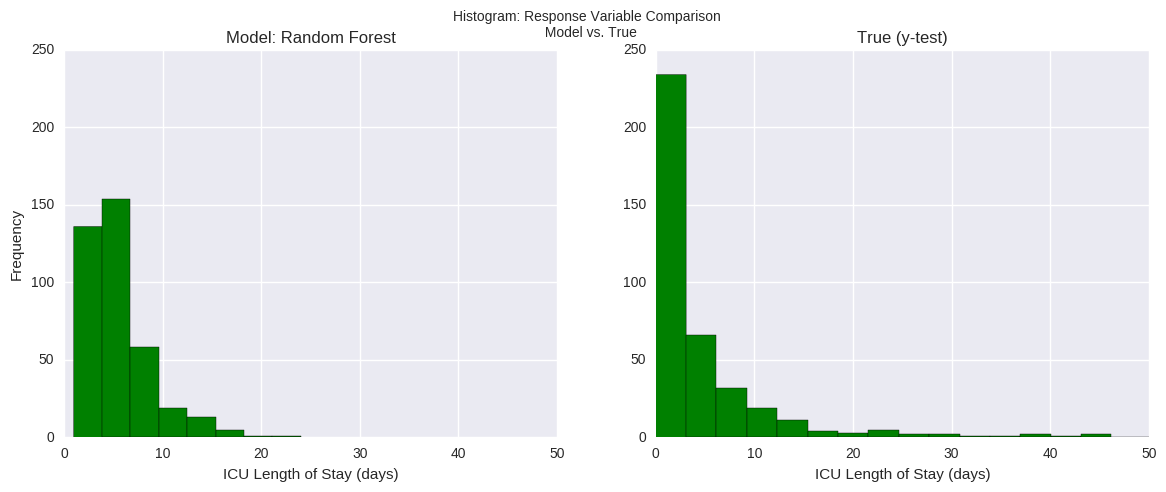

In [67]:
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
plt.hist(np.round(rf_pred), bins=8, color='g')
plt.title("Model: Random Forest")
plt.xlabel('ICU Length of Stay (days)')
plt.ylabel('Frequency')
plt.xlim([0,50])
plt.ylim([0, 250])
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.hist(np.round(y_test), bins=25, color='g')
plt.title("True (y-test)")
plt.xlabel('ICU Length of Stay (days)')
plt.xlim([0,50])
plt.ylim([0, 250])
plt.legend(loc='upper right')
plt.suptitle('Histogram: Response Variable Comparison \n Model vs. True')

plt.show()

### Metrics

#### Root Mean Squared Error (RMSE)
Indicates the *absolute fit* of the model to the data. In other words, how close the observed data points are to the model's predicted values.

Also, it is the standard deviation of unexplained variance (residuals).

In [68]:
rf_rmse = RMSE(rf_pred, y_test)
print "RMSE = %.3f days" % rf_rmse

RMSE = 8.367 days


In [69]:
print "[%.2f,%.2f]" % (y_test.min(), y_test.max())

[0.21,76.92]


The Random Forest regression model has an RMSE value of 8.37 days, which is relatively low compared to the response range.

#### Mean Absolute Error
The Mean Absolute Error measures how close the model's predictions are to the observed values.

In [70]:
rf_mae = MAE(rf_pred, y_test)
print "MAE = %.3f days" % rf_mae

MAE = 2.943 days


The average difference between prediction and observation is 2.94 days, which is relatively low.

#### R<sup>2</sup>: Coefficient of Determination
R<sup>2</sup> quantifies the goodness of fit of the linear model. More specifically, it depicts the predictive power of the model.

Range: [0, 1]

In [71]:
rf_r2 = r2(rf_pred, y_test)
print "r2 = %.2f" % rf_r2

r2 = -0.02


The Random Forest model has poor predictive power.The negative R<sup>2</sup> is out of range, indicating that the model can be arbitrarily worse. 

## BoxCox Transformations

A BoxCox transformation is a normalization approach that is applicable to only continuous values. Features that are categorical or binary in nature are not appropriate due to the semantics of their numerical values.

**Note**: Box-Cox transformations can only handle positive values, non-positive values, including 0, are unapplicable.

In [72]:
scaled_X_train_boxcox = scaled_X_train.copy()
scaled_X_test_boxcox = scaled_X_test.copy()

# # inverse transform
orig_X_train_boxcox = scaler.inverse_transform(scaled_X_train_boxcox)
orig_X_test_boxcox = scaler.inverse_transform(scaled_X_test_boxcox)

# Box Cox Transformation
train_ntran_bc = stats.boxcox(orig_X_train_boxcox[:,4])[0]
test_ntran_bc = stats.boxcox(orig_X_test_boxcox[:, 4])[0]

# Replace applicable features
scaled_X_train_boxcox[:,4] = train_ntran_bc
scaled_X_test_boxcox[:,4] = test_ntran_bc

### Model: Linear Regression

In [113]:
lr_model_bc, lr_pred_bc, lr_p_bc, lr_score_bc = gridsearch(scaled_X_train_boxcox, scaled_X_test_boxcox, y_train)
print "Best Parameters: ", lr_p_bc
print "Best Grid Search Score: ", lr_score_bc
print "Best Estimator: ", lr_model_bc

Best Parameters:  {'normalize': False, 'fit_intercept': True}
Best Grid Search Score:  0.000165339304871
Best Estimator:  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)


#### Compare Predictions

In [114]:
lr_pred_bc[-10:]

array([ 6.69045792,  3.88354024,  7.80201974,  2.85355684,  6.98648364,
        2.86520088,  4.18569205,  4.32052885,  4.08528561,  4.67124809])

In [115]:
y_test[-10:]

array([ 11.6744,   9.2824,  21.8131,  11.6055,   4.5255,   4.0701,
         1.1331,   2.7381,   0.6534,   3.0686])

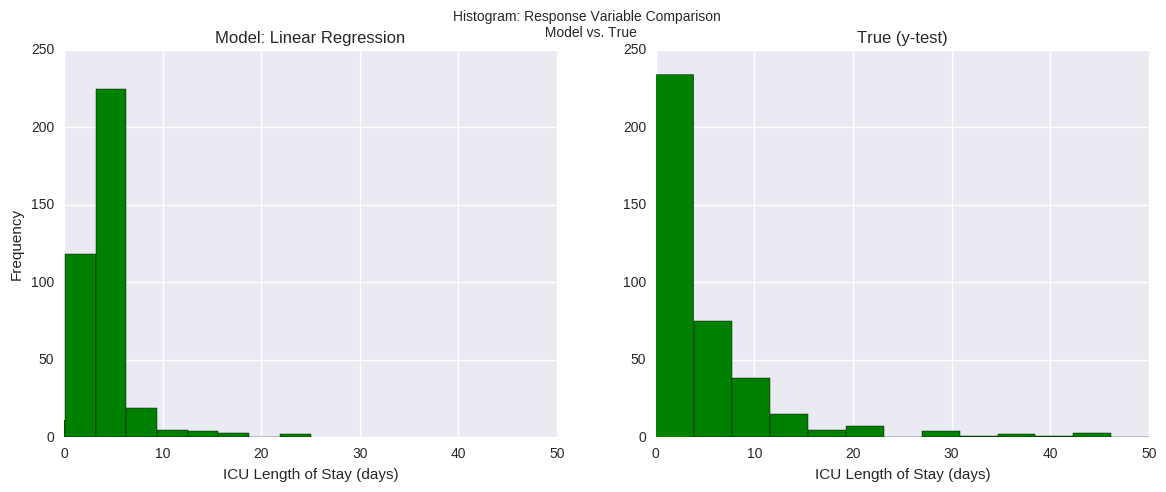

In [124]:
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
plt.hist(np.round(lr_pred_bc), bins=9, color='g')
plt.title("Model: Linear Regression")
plt.xlabel('ICU Length of Stay (days)')
plt.ylabel('Frequency')
plt.xlim([0,50])
plt.ylim([0, 250])
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.hist(np.round(y_test), bins=20, color='g')
plt.title("True (y-test)")
plt.xlabel('ICU Length of Stay (days)')
plt.xlim([0,50])
plt.ylim([0, 250])
plt.legend(loc='upper right')
plt.suptitle('Histogram: Response Variable Comparison \n Model vs. True')

plt.show()

#### Metrics

1. RMSE
2. MAE
3. R<sup>2</sup>

In [126]:
lr_rmse_bc = RMSE(lr_pred_bc, y_test)
print "ICU LOS Range: [%.2f,%.2f]" % (y_test.min(), y_test.max())
print "RMSE = %.3f days" % lr_rmse_bc
print
lr_mae_bc = MAE(lr_pred_bc, y_test)
print "MAE = %.3f days" % lr_mae_bc
print
lr_r2_bc = r2(lr_pred_bc, y_test)
print "r2 = %.3f" % lr_r2_bc

ICU LOS Range: [0.21,76.92]
RMSE = 8.429 days

MAE = 2.686 days

r2 = -0.037


The Linear Regression model with Box Cox transformation of applicable features has slightly worse metrics compared to its counterpart with standard scaling. 

The `RMSE` and `MAE` increased by 0.2 and 0.1 days respectively. The values are still low, indicating small prediction errors.

On the contrary, `R`<sup>2</sup> remains to be sup-bar with an abysmal -0.04 value. The model has poor predictive power.

### Model: Support Vector Regression

In [147]:
svr_model_bc, svr_pred_bc, svr_p_bc, svr_score_bc = svr_gridsearch(scaled_X_train_boxcox, scaled_X_test_boxcox, y_train)
print "Best Parameters: ", svr_p_bc
print "Best Grid Search Score: ", svr_score_bc
print "Best Estimator: ", svr_model_bc

Best Parameters:  {'kernel': 'rbf', 'C': 10, 'gamma': 10}
Best Grid Search Score:  -0.0249602572401
Best Estimator:  SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=10,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


#### Compare Predictions

In [148]:
svr_pred_bc[-10:]

array([ 4.01615202,  4.01615201,  4.01144475,  4.01615202,  4.01615201,
        3.76325061,  4.01605114,  4.01814433,  4.01618664,  4.01599192])

In [149]:
y_test[-10:]

array([ 11.6744,   9.2824,  21.8131,  11.6055,   4.5255,   4.0701,
         1.1331,   2.7381,   0.6534,   3.0686])

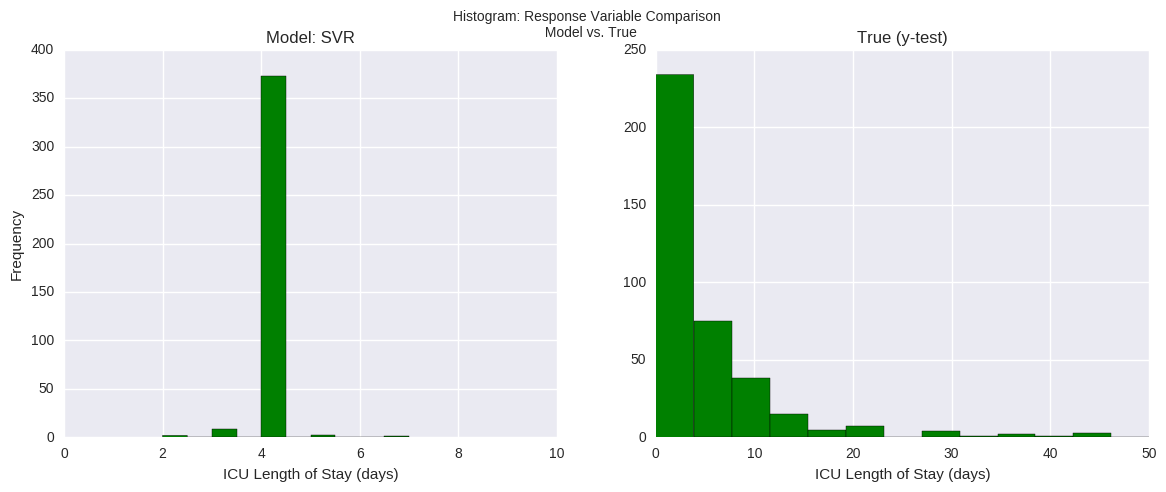

In [155]:
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
plt.hist(np.round(svr_pred_bc), color='g')
plt.title("Model: SVR")
plt.xlabel('ICU Length of Stay (days)')
plt.ylabel('Frequency')
plt.xlim([0,10])
# plt.ylim([0, 120])
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.hist(np.round(y_test), bins=20, color='g')
plt.title("True (y-test)")
plt.xlabel('ICU Length of Stay (days)')
plt.xlim([0,50])
plt.ylim([0, 250])
plt.legend(loc='upper right')
plt.suptitle('Histogram: Response Variable Comparison \n Model vs. True')

plt.show()

#### Metrics

1. RMSE
2. MAE
3. R<sup>2</sup>

In [156]:
svr_rmse_bc = RMSE(svr_pred_bc, y_test)
print "ICU LOS Range: [%.2f,%.2f]" % (y_test.min(), y_test.max())
print "RMSE = %.3f days" % svr_rmse_bc
print
svr_mae_bc = MAE(svr_pred_bc, y_test)
print "MAE = %.3f days" % svr_mae_bc
print
svr_r2_bc = r2(svr_pred_bc, y_test)
print "r2 = %.3f" % svr_r2_bc

ICU LOS Range: [0.21,76.92]
RMSE = 8.395 days

MAE = 2.381 days

r2 = -0.029


The Support Vector Regression model with Box Cox transformation of applicable features has similar metrics compared to its counterpart with standard scaling. The metrics did not change at all. 

The `RMSE` and `MAE` values are still low and indicate small prediction errors. `R`<sup>2</sup> remains inferior and shows that the model has poor predictive power.

### Model: k-Nearest Neighbors

In [74]:
knn_model_bc = KNeighborsRegressor(n_neighbors=5, weights='uniform') # look at 5 closest neighbors
knn_model_bc.fit(scaled_X_train_boxcox, y_train) # fit model on training data
knn_pred_bc = knn_model_bc.predict(scaled_X_test_boxcox)

#### Compare Predictions

In [75]:
knn_pred_bc[-10:]

array([ 6.52692,  3.86476,  7.01408,  3.60196,  6.88756,  2.22222,
        2.54172,  6.52692,  2.48348,  3.86476])

In [76]:
y_test[-10:]

array([ 11.6744,   9.2824,  21.8131,  11.6055,   4.5255,   4.0701,
         1.1331,   2.7381,   0.6534,   3.0686])

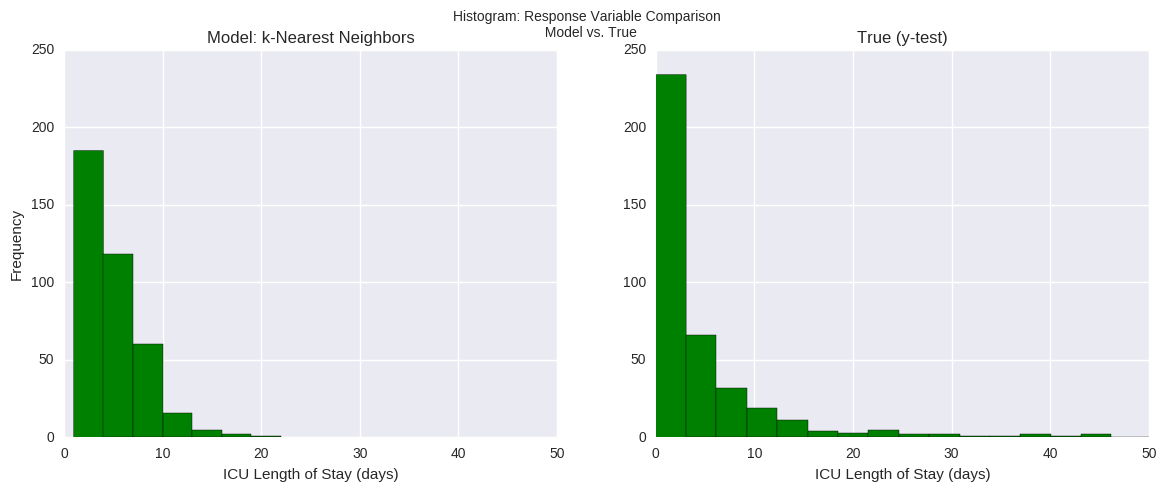

In [80]:
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
plt.hist(np.round(knn_pred_bc), bins=7, color='g')
plt.title("Model: k-Nearest Neighbors")
plt.xlabel('ICU Length of Stay (days)')
plt.ylabel('Frequency')
plt.xlim([0,50])
plt.ylim([0, 250])
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.hist(np.round(y_test), bins=25, color='g')
plt.title("True (y-test)")
plt.xlabel('ICU Length of Stay (days)')
plt.xlim([0,50])
plt.ylim([0, 250])
plt.legend(loc='upper right')
plt.suptitle('Histogram: Response Variable Comparison \n Model vs. True')

plt.show()

#### Metrics

1. RMSE
2. MAE
3. R<sup>2</sup>

In [95]:
knn_rmse_bc = RMSE(knn_pred_bc, y_test)
print "ICU LOS Range: [%.2f,%.2f]" % (y_test.min(), y_test.max())
print "RMSE = %.3f days" % knn_rmse_bc
print
knn_mae_bc = MAE(knn_pred_bc, y_test)
print "MAE = %.3f days" % knn_mae_bc
print
knn_r2_bc = r2(knn_pred_bc, y_test)
print "r2 = %.3f" % knn_r2_bc

ICU LOS Range: [0.21,76.92]
RMSE = 8.500 days

MAE = 2.671 days

r2 = -0.055


The k-Nearest Neighbors model with Box Cox transformation of applicable features has slightly worse metrics compared to its counterpart with standard scaling. 

The `RMSE` value did not change, but `MAE` increased by 0.2. The values are still low, indicating small prediction error.

On the contrary, `R`<sup>2</sup> remains to be sup-bar with an abysmal -0.06 value. The model has poor predictive power.

### Model: Random Forest

In [82]:
rf_model_bc, rf_pred_bc, rf_p_bc, rf_score_bc, rf_imp_bc = rf_gridsearch(scaled_X_train_boxcox, scaled_X_test_boxcox, y_train)
print "Best Parameters: ", rf_p_bc
print "Best Grid Search Score: ", rf_score_bc
print "Best Estimator: ", rf_model_bc

Best Parameters:  {'n_estimators': 10, 'criterion': 'mse'}
Best Grid Search Score:  -0.378151511741
Best Estimator:  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=-1, oob_score=False, random_state=2,
           verbose=0, warm_start=False)


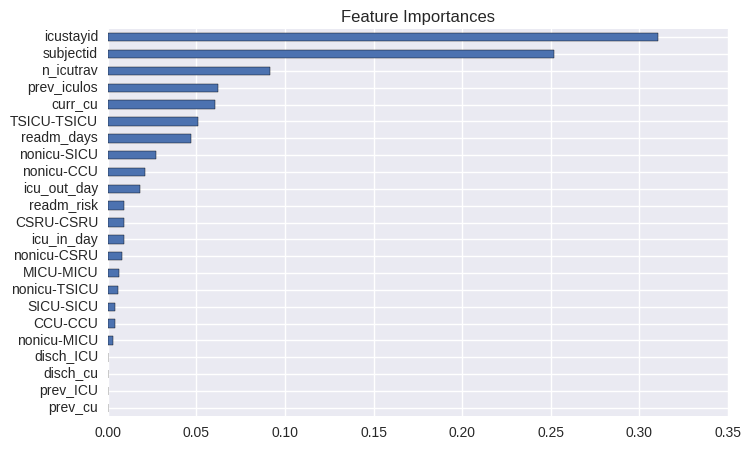

In [92]:
plt.figure(figsize=(8,5))
# feats = data.drop('icu_los', axis=1)
feat_imp_bc = pd.Series(rf_imp_bc, 
                     index=feats.columns.values).sort_values(ascending=True)
feat_imp_bc.plot(kind='barh')
plt.title('Feature Importances')

#### Compare Predictions

In [84]:
rf_pred_bc[-10:]

array([ 13.9212 ,  10.25472,   9.79834,  16.17401,  13.26611,  11.52077,
        16.21562,  11.0287 ,   9.04833,   9.49219])

In [85]:
y_test[-10:]

array([ 11.6744,   9.2824,  21.8131,  11.6055,   4.5255,   4.0701,
         1.1331,   2.7381,   0.6534,   3.0686])

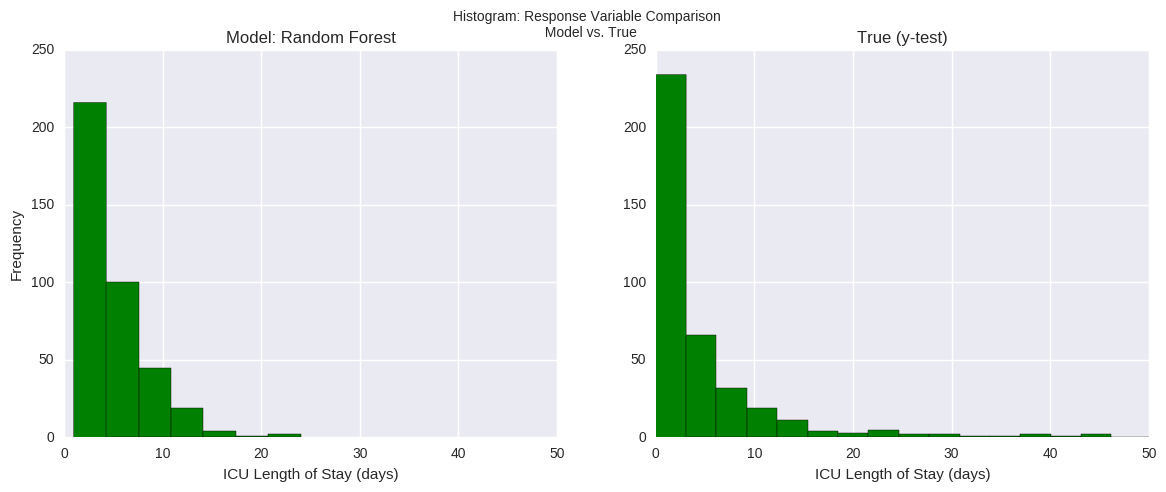

In [86]:
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
plt.hist(np.round(rf_pred_bc), bins=7, color='g')
plt.title("Model: Random Forest")
plt.xlabel('ICU Length of Stay (days)')
plt.ylabel('Frequency')
plt.xlim([0,50])
plt.ylim([0, 250])
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.hist(np.round(y_test), bins=25, color='g')
plt.title("True (y-test)")
plt.xlabel('ICU Length of Stay (days)')
plt.xlim([0,50])
plt.ylim([0, 250])
plt.legend(loc='upper right')
plt.suptitle('Histogram: Response Variable Comparison \n Model vs. True')

plt.show()

#### Metrics

1. RMSE
2. MAE
3. R<sup>2</sup>

In [96]:
rf_rmse_bc = RMSE(rf_pred_bc, y_test)
print "ICU LOS Range: [%.2f,%.2f]" % (y_test.min(), y_test.max())
print "RMSE = %.3f days" % rf_rmse_bc
print
rf_mae_bc = MAE(rf_pred_bc, y_test)
print "MAE = %.3f days" % rf_mae_bc
print
rf_r2_bc = r2(rf_pred_bc, y_test)
print "r2 = %.3f" % rf_r2_bc

ICU LOS Range: [0.21,76.92]
RMSE = 8.609 days

MAE = 2.929 days

r2 = -0.082


The Random Forest model with Box Cox transformation of applicable features has slightly worse metrics compared to its counterpart with standard scaling. 

The `RMSE` increased by 0.2 days, but `MAE` remains unchanged. The values are still low, indicating low prediction error. `R`<sup>2</sup> score got worse by .06, indicating an even inferior predictive power.

## Conclusion
Model | RMSE | MAE | R<sup>2</sup> |
:-----|:----:|:---:| :------------:|
Linear Regression|8.2|2.6|0.02
Support Vector Regression (*kernel: rbf*)|8.4|2.4|-0.03
k-Nearest Neighbors|8.5|2.5|-0.05
Random Forest|8.4|2.9|-0.02

All regression models have roughly similar metrics. They all have small predictive errors with relatively low RMSE and MAE values. On the contrary, they all have very poor R<sup>2</sup> scores, demonstrating poor predictive power.

#### RMSE
In regards to RMSE, the models have relatively decent performances in the prediction of ICU length of stay for new, unseen data. The RMSE values are greater than the MAE values for all models, suggesting that there are a higher frequency of larger residuals as the metric penalizes bigger discrepancies.

#### MAE
All models are very strong in terms of their mean absolute errors with values ranging from 2-3 days for the ICU length of stays. Essentially, the models are only off, on average, 2-3 days in their prediction.

#### R<sup>2</sup> - Coefficient of Determination
The very low R<sup>2</sup> values indicate that the models have very poor predictive power. 

More specifically, the k-Nearest Neighbors model is the weakest model and has a negative coefficient of determination. This suggests that the model is not generalizable to future unseen data and is possibly attributed to the fact that it's approach is "lazy learning". The model does not encompass a training phase and instead holds the entire training data and builds its model at the time of prediction. A drawback of this approach is longer run-time.

### Box Cox Transformation
Box Cox transformation was performed on only the following feature(s): `n_icutrav`. These feature(s) are the only one(s) that have positive values and are continuous. Other unapplicable features either had non-positive values or were categorical in nature.

Model | RMSE | MAE | R<sup>2</sup> |
:-----|:----:|:---:| :------------:|
Linear Regression|8.4|2.7|-0.04
Support Vector Regression (*kernel: rbf*)|8.4|2.4|-0.03
k-Nearest Neighbors|8.4|2.7|-0.06
Random Forest|8.6|2.9|-0.08

This normalization approach gave no improvements to the model. All metrics indicate that the transformation actually slightly worsened, if not yielded the same results as the models' "standard scaling" counterparts. 

Thus, it's conluded that the transformation is not appropriate for this dataset.

### Feature Traversal Full-Picture vs. Interval
Prior endeavors viewed the composite dataset through specific intervals, which were time windows serving as cut-offs for ICU readmissions.

The transition from this approach yielded improvements in overall RMSE values (decreased by 2-3 days) with a trade-off in slightly decreased MAE (0.5-1.0 days). Thus, indicating the current feature engineering approach has less discrepancies of larger values (or outliers). In other words, this approach has a lower frequency of large prediction errors.